# HCP Task Test-Retest Baselines

This notebook details:<br>
(0) identification of the HCP retest subjects<br>
(1) the download of the HCP test retest task contrast data<br>
(2) the computation of group average maps<br>
(3) the calculation of test-restest baseline scores (for both full and residualized task maps),<br>
including: accuracy (correlation), discriminability, vertex-wise accuracy, and within parcel discriminability<br>
(4) pinpointing of the most discriminable task contrasts<br>

**Inputs**

Indiviudal task contrasts (test & retest)<br>
`HCP_1200/{subj}/MNINonLinear/Results/tfMRI_{para}/tfMRI_{para}_hp200_s2_level2_MSMAll.feat/{subj}_tfMRI_{para}_level2_hp200_s2_MSMAll.dscalar.nii`, <br>
`HCP_Retest/{subj}/MNINonLinear/Results/tfMRI_{para}/tfMRI_{para}_hp200_s2_level2_MSMAll.feat/{subj}_tfMRI_{para}_level2_hp200_s2_MSMAll.dscalar.nii`, 

Parcellations (for 2):<br>
`hcp.mmp.map_all[:29696]`<br>
`brainspace.datasets.load_parcellation('schaefer')`

**Outputs**

list of the 45 retest subjects<br>
`/home/users/robert.scholz2/bigdata/hcp_retest_subjects.txt`

task maps for 40 retest subjects (those that had all nessesary files)<br>
dict, keys: task_names, values: list of tuples (test_contrast, retest_contrast), each contrast of shape (29696))<br>
`results/retest_hcp40.task_maps.npy`

mean task contrasts, array of shape (task=47, vertcies)<br>
`results/retest_hcp40.test.mean_task_maps.npy` -

retest scores, as python dictionary<br>
`results/scores/retest_hcp40.retest_scores.npy`

contrast_ids_to_show <br>
`[8, 38, 16, 2, 27, 24, 5, 44, 21]`

In [1]:
import scipy.stats
import numpy as np
np.set_printoptions(suppress=True)
import nibabel as nib
nib.imageglobals.logger.setLevel(40)
import hcp_utils as hcp
import fnmatch
import os
f= lambda str: eval("f'" + f"{str}" + "'")

from lib.aws_tools import download_aws_file

from tqdm import tqdm
from matplotlib import pyplot as plt 
from IPython.display import clear_output
from lib.plotting import bc # for coloring the console output
from lib.plotting import plot_bars, plot_29k
import sys
sys.path.append("/home/mpg02/MLSC/robert.scholz2/.local/lib/python3.7/site-packages")
import cmasher as cmr
import cmcrameri.cm as cmc

from sklearn.metrics import r2_score, explained_variance_score
from lib.default_config import contrast_info, task_fmri_sam, tmsmall, smooth_lv, tmap_type, full_subj_path
from lib.stats import compute_all_scores, compute_scores, comp_dice, comp_corr

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from lib.stats import comp_dice, comp_corr, comp_tsss_similiarity, comp_cosine_similiarity
from lib.stats import compute_all_scores, compute_scores, comp_dice, comp_corr, r2_score
from lib.stats import compute_batch_differentiability_score
desired_scores = {"r2_score": r2_score, "corr": comp_corr, "dice": comp_dice, "tsss": comp_tsss_similiarity, "cosine": comp_cosine_similiarity};


In [3]:
from lib.plotting import infer_colorbar, paste_centrally
def make_tight_29k(data, cbar=False, cmap='cmr.wildfire', vmin=None, vmax=None, cminmax=True, title=None):
  if cminmax: plot_29k(data, title=None, cmap=cmap, colorbar=False, center_min_max=cminmax);
  else: plot_29k(data, title=None, cmap=cmap, colorbar=False, center_min_max=False, vmin=vmin, vmax=vmax);
  if not(title is None):
    plt.title(title,  y=1.02, x=-0.99, pad=0, ha='left', va='top', weight='bold')
  pil_img = fig2tightPIL(close_fig=1, dpi=300)
  if cbar: 
    cb = infer_colorbar(data, cminmax=cminmax, vmin=None, vmax=None, cmap=cmap, aspect=10, shrink=0.2);
    cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
    pil_img = paste_centrally(pil_img, cbimg, uc=0.8);
  return pil_img;

In [4]:
# highest differentiated contrast per task across individuals
# this is derived in the end, but already used for plotting earlier on, and hence hardcoded
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]

# Outline

# Find and download HCP retest data

## find the retest subjects

In [ ]:
def list_aws(bucket="s3://hcp-openaccess", \
             add="/HCP_1200", postf = lambda line: line.split(" ")[-1], no_sign=False):
  #out = !python -m awscli s3 ls --no-sign-request {bucket}{add}
  if no_sign:  bucket = "--no-sign-request " + bucket; 
  out = !python -m awscli s3 ls {bucket}{add}
  return [postf(line) for line in out]

#https://hcp-openaccess.s3.us-east-1.amazonaws.com/HCP_Retest/105923/MNINonLinear/Results/tfMRI_RELATIONAL_RL/
retest_subjs = list_aws(add="/HCP_Retest/", postf = lambda l: l.split(" ")[-1].rstrip("/"))
print(len(retest_subjs), retest_subjs[:10])
np.savetxt('/home/users/robert.scholz2/bigdata/hcp_retest_subjects.txt', retest_subjs, fmt="%s")
#!cat /home/users/robert.scholz2/bigdata/hcp_retest_subjects.txt

## Download task contrast files

In [5]:
retest_subjs = np.loadtxt('/home/users/robert.scholz2/bigdata/hcp_retest_subjects.txt').astype(int).astype(str)

The files that we are looking for look like 
`scratch/users/robert.scholz2/HCP_1200/100206/MNINonLinear/Results/tfMRI_LANGUAGE/tfMRI_LANGUAGE_hp200_s2_level2_MSMAll.feat/100206_tfMRI_LANGUAGE_level2_hp200_s2_MSMAll.dscalar.nii`

In [6]:
# !cat /home/users/robert.scholz2/bigdata/hcp_retest_subjects.txt
len(retest_subjs), retest_subjs[:3]

(45, array(['103818', '105923', '111312'], dtype='<U21'))

In [25]:
full_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
#full_subjs2=np.loadtxt("data/subjs_hcp255_full_unrelated.txt").astype(int).astype(str);
print([subj for subj in full_subjs2 if not(subj in full_subjs)])
overlap=[subj for subj in full_subjs if subj in retest_subjs]
print(len(overlap), overlap)

['134627']
9 ['135528', '139839', '146129', '185442', '204521', '433839', '562345', '599671', '660951']


In [99]:
## This cell basically lists all results files for a given subject
## these files will be filstered later on

from tqdm import tqdm 

#files = {}
for subj in tqdm(retest_subjs):
  if subj in files.keys(): continue; 
  out = !python -m awscli s3 ls --recursive s3://hcp-openaccess/HCP_1200/{subj}/MNINonLinear/Results/
  files[subj] = out.copy()

#np.save("data/available_task_contrast_files_for_the_45_retest_subjects.npy", files)

100%|██████████| 45/45 [06:10<00:00,  8.24s/it]


In [4]:
available_files = np.load("data/available_task_contrast_files_for_the_45_retest_subjects.npy", allow_pickle=1).item()

In [5]:
# just filter out the relevant cifti files at the desired smoothing level (2mm) and alignment (MSMAll)
xfiles = [o.split(" ")[-1] for o in available_files["103818"]]
matching = fnmatch.filter(xfiles, "*s2_MSMAll.dscalar.nii")
len(matching), matching[:3]

(7,
 ['HCP_1200/103818/MNINonLinear/Results/tfMRI_EMOTION/tfMRI_EMOTION_hp200_s2_level2_MSMAll.feat/103818_tfMRI_EMOTION_level2_hp200_s2_MSMAll.dscalar.nii',
  'HCP_1200/103818/MNINonLinear/Results/tfMRI_GAMBLING/tfMRI_GAMBLING_hp200_s2_level2_MSMAll.feat/103818_tfMRI_GAMBLING_level2_hp200_s2_MSMAll.dscalar.nii',
  'HCP_1200/103818/MNINonLinear/Results/tfMRI_LANGUAGE/tfMRI_LANGUAGE_hp200_s2_level2_MSMAll.feat/103818_tfMRI_LANGUAGE_level2_hp200_s2_MSMAll.dscalar.nii'])

In [14]:
# Collect all the files to download
files2downl=[]
files_per_sub = np.zeros(len(retest_subjs))
for n, subj in enumerate(retest_subjs):
   xfiles = [o.split(" ")[-1] for o in files[subj]]
   matching = fnmatch.filter(xfiles, "*s2_MSMAll.dscalar.nii")
   for f in matching: 
     files2downl.append(f)
     files_per_sub[n] = files_per_sub[n]+1
   if files_per_sub[n]<7:
    for f in files2downl[-files_per_sub[n].astype(int):]: print(f)
    
len(files2downl) # should be 7 paradigms * 10 subjects

HCP_1200/144226/MNINonLinear/Results/tfMRI_GAMBLING/tfMRI_GAMBLING_hp200_s2_level2_MSMAll.feat/144226_tfMRI_GAMBLING_level2_hp200_s2_MSMAll.dscalar.nii
HCP_1200/144226/MNINonLinear/Results/tfMRI_LANGUAGE/tfMRI_LANGUAGE_hp200_s2_level2_MSMAll.feat/144226_tfMRI_LANGUAGE_level2_hp200_s2_MSMAll.dscalar.nii
HCP_1200/144226/MNINonLinear/Results/tfMRI_MOTOR/tfMRI_MOTOR_hp200_s2_level2_MSMAll.feat/144226_tfMRI_MOTOR_level2_hp200_s2_MSMAll.dscalar.nii
HCP_1200/144226/MNINonLinear/Results/tfMRI_RELATIONAL/tfMRI_RELATIONAL_hp200_s2_level2_MSMAll.feat/144226_tfMRI_RELATIONAL_level2_hp200_s2_MSMAll.dscalar.nii
HCP_1200/144226/MNINonLinear/Results/tfMRI_SOCIAL/tfMRI_SOCIAL_hp200_s2_level2_MSMAll.feat/144226_tfMRI_SOCIAL_level2_hp200_s2_MSMAll.dscalar.nii
HCP_1200/144226/MNINonLinear/Results/tfMRI_WM/tfMRI_WM_hp200_s2_level2_MSMAll.feat/144226_tfMRI_WM_level2_hp200_s2_MSMAll.dscalar.nii
HCP_1200/169343/MNINonLinear/Results/tfMRI_EMOTION/tfMRI_EMOTION_hp200_s2_level2_MSMAll.feat/169343_tfMRI_EMOTION_l

311

In [10]:
files_per_sub

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 6., 7., 7., 7., 7.,
       7., 6., 7., 7., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 6., 7.])

In [17]:
# filter out the subject that have all the nessesary files
full_rt_subjs = retest_subjs[files_per_sub==7]
len(full_rt_subjs),full_rt_subjs

(41,
 array(['103818', '105923', '111312', '114823', '115320', '122317',
        '125525', '130518', '135528', '137128', '139839', '143325',
        '146129', '149337', '149741', '151526', '158035', '172332',
        '175439', '185442', '187547', '192439', '194140', '195041',
        '200109', '200614', '204521', '250427', '287248', '341834',
        '433839', '562345', '599671', '601127', '627549', '660951',
        '662551', '783462', '859671', '861456', '917255'], dtype='<U21'))

In [22]:
# download all the files
failed =[]
for fn in tqdm(files2downl):
  local_path = download_aws_file(fn); # download standard contrast
  if local_path == False: failed.append(fn);
  rt_fn = "HCP_Retest/" + "/".join(fn.split("/")[1:])
  local_path = download_aws_file(rt_fn)
  if local_path == False: failed.append(rt_fn);
  clear_output(wait=True)
len(failed)

100%|██████████| 311/311 [00:12<00:00, 25.23it/s]


4

In [24]:
# show for which subjects the download failed
failed_subjs = [s for s in retest_subjs if np.any([s in f for f in failed])]
failed_subjs, failed

(['627549'],
 ['HCP_Retest/627549/MNINonLinear/Results/tfMRI_EMOTION/tfMRI_EMOTION_hp200_s2_level2_MSMAll.feat/627549_tfMRI_EMOTION_level2_hp200_s2_MSMAll.dscalar.nii',
  'HCP_Retest/627549/MNINonLinear/Results/tfMRI_LANGUAGE/tfMRI_LANGUAGE_hp200_s2_level2_MSMAll.feat/627549_tfMRI_LANGUAGE_level2_hp200_s2_MSMAll.dscalar.nii',
  'HCP_Retest/627549/MNINonLinear/Results/tfMRI_RELATIONAL/tfMRI_RELATIONAL_hp200_s2_level2_MSMAll.feat/627549_tfMRI_RELATIONAL_level2_hp200_s2_MSMAll.dscalar.nii',
  'HCP_Retest/627549/MNINonLinear/Results/tfMRI_SOCIAL/tfMRI_SOCIAL_hp200_s2_level2_MSMAll.feat/627549_tfMRI_SOCIAL_level2_hp200_s2_MSMAll.dscalar.nii'])

In [27]:
# these are the 40 subjects for which we have all the files
full_rt_subjs = np.array([s for s in retest_subjs[files_per_sub==7] if not(s in failed_subjs)])
len(full_rt_subjs),full_rt_subjs

(40,
 array(['103818', '105923', '111312', '114823', '115320', '122317',
        '125525', '130518', '135528', '137128', '139839', '143325',
        '146129', '149337', '149741', '151526', '158035', '172332',
        '175439', '185442', '187547', '192439', '194140', '195041',
        '200109', '200614', '204521', '250427', '287248', '341834',
        '433839', '562345', '599671', '601127', '660951', '662551',
        '783462', '859671', '861456', '917255'], dtype='<U6'))

## Load retest contrasts, concatenate and save

In [7]:
def load_subj_full_task_data(subj, contrast_ids, paradigms, dtype=np.float32, v=False, ret_keys=False, \
                            local_dir = "/scratch/users/robert.scholz2/", hcp_subdir="HCP_1200"):
  data = {}
  for para in paradigms: 
    if v: print(para, end=" ")
    fn = local_dir + f"{hcp_subdir}/{subj}/MNINonLinear/Results/tfMRI_{para}/tfMRI_{para}_hp200_s2_level2_MSMAll.feat/{subj}_tfMRI_{para}_level2_hp200_s2_MSMAll.dscalar.nii"
    cifti = nib.load(fn)
    cnames = cifti.header.get_axis(0).name;
    darr = cifti.get_fdata()[:,slice(0, 29696)];
    data.update( {name : darr[i] for i, name in enumerate(cnames)})
    #mask = [contains_any(name, contrast_ids) for name in cnames]
    #cifti.get_fdata()[mask,slice(0, 29696)].shape
  
  if v: print(len(data.keys()))
  dkeys = list(data.keys())
  #tdata = np.array([data[ [x for x in data.keys() if x.startswith(subj+"_"+cid)][0] ] for cid in contrast_ids])
  tdata = []
  contained=[]
  if isinstance(contrast_ids, str) and contrast_ids == "all":
    for key in dkeys:
      if v: print(subj+"_"+cid[:-1], "\t", keys[0])
      tdata.append(data[key])
      contained.append(key)
  else:
    for cid in contrast_ids:
      keys = [x for x in dkeys if x.startswith(subj+"_"+cid[:-1])]
      if v: print(subj+"_"+cid[:-1], "\t", keys[0])
      tdata.append(data[keys[0]])
      contained.append(keys[0])
  if ret_keys: return np.array(tdata).T.astype(dtype), contained;
  return np.array(tdata).T.astype(dtype);


In [8]:
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
paradigms = np.unique([c[0] for c in contrast_info]).tolist()


In [40]:
subj0_task_names = load_subj_full_task_data(full_rt_subjs[0], unique_contrasts, paradigms , ret_keys=1)[1]
len(subj0_task_names), subj0_task_names[:10]

(47,
 ['103818_tfMRI_EMOTION_level2_FACES_hp200_s2_MSMAll',
  '103818_tfMRI_EMOTION_level2_SHAPES_hp200_s2_MSMAll',
  '103818_tfMRI_EMOTION_level2_FACES-SHAPES_hp200_s2_MSMAll',
  '103818_tfMRI_GAMBLING_level2_PUNISH_hp200_s2_MSMAll',
  '103818_tfMRI_GAMBLING_level2_REWARD_hp200_s2_MSMAll',
  '103818_tfMRI_GAMBLING_level2_REWARD-PUNISH_hp200_s2_MSMAll',
  '103818_tfMRI_LANGUAGE_level2_MATH_hp200_s2_MSMAll',
  '103818_tfMRI_LANGUAGE_level2_STORY_hp200_s2_MSMAll',
  '103818_tfMRI_LANGUAGE_level2_STORY-MATH_hp200_s2_MSMAll',
  '103818_tfMRI_MOTOR_level2_CUE_hp200_s2_MSMAll'])

In [42]:
test_data = {subj: load_subj_full_task_data(subj, unique_contrasts, paradigms, v=0, hcp_subdir="HCP_1200") for subj in tqdm(full_rt_subjs)}
rtst_data = {subj: load_subj_full_task_data(subj, unique_contrasts, paradigms, v=0, hcp_subdir="HCP_Retest") for subj in tqdm(full_rt_subjs)}

100%|██████████| 40/40 [03:00<00:00,  4.52s/it]


In [130]:
tdata_raw = np.array([d for s,d in test_data.items()])
rdata_raw = np.array([d for s,d in rtst_data.items()])

In [56]:
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.npy"
info = dict(paradigms=paradigms, unique_contrasts=unique_contrasts, full_rt_subjs=full_rt_subjs, zscore=False, dim="n_subjs, n_vertices, n_contrasts")
print(tdata.shape, rdata.shape)
np.save(fn, dict(info=info, test_data = tdata_raw, retest_data = rdata_raw ))
!ls -ash {fn}

(40, 29696, 47) (40, 29696, 47)
426M /scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.npy


In [131]:
tdata = scipy.stats.zscore(tdata_raw, axis=1)
rdata = scipy.stats.zscore(rdata_raw, axis=1)

In [135]:
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy"
info = dict(paradigms=paradigms, unique_contrasts=unique_contrasts, full_rt_subjs=full_rt_subjs, zscore=True, dim="n_subjs, n_vertices, n_contrasts")
print(tdata.shape, rdata.shape)
np.save(fn, dict(info=info, test_data = tdata, retest_data = rdata ))
!ls -ash {fn}

(40, 29696, 47) (40, 29696, 47)
426M /scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy


# Individual Retest Examples

In [21]:
# loading task data
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
print(payload.keys())
tdata = payload["test_data"]
rdata = payload["retest_data"]

unique_contrasts = payload["info"]["unique_contrasts"]
subjs = payload["info"]["full_rt_subjs"]
zscore = payload["info"]["zscore"]
zscore, tdata.shape

dict_keys(['info', 'test_data', 'retest_data'])


(True, (40, 29696, 47))

In [22]:
from IPython.display import display # to display images
from lib.plotting import plot_gen_surf2, image_grid, fig2tightPIL
import brainspace
stub = os.path.dirname(brainspace.__file__) + "/datasets/surfaces/"

transform = {"img1": hcp.left_cortex_data, "img2": hcp.left_cortex_data}
pcf = ["img1_0_180_6.4", "img2_0_180_6.4", "img1_0_0_6.4", "img2_0_0_6.4"]
surfs = [stub+"conte69_32k_lh.gii"]*2

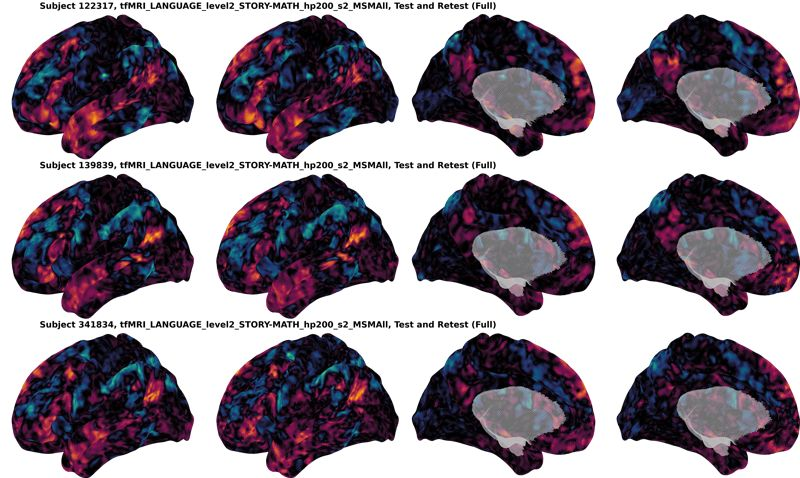

In [138]:
sample_subj_indxs = np.array( [5, 10, 29]);
v = np.absolute(tdata[sample_subj_indxs,:, tn]).max()
tn = 8

full_retest_imgs=[]
for sn in sample_subj_indxs:
  plot_gen_surf2([tdata[sn,:, tn], rdata[sn,:, tn]], transform=transform, surfs=surfs, plot_conf=pcf, vmin=-v, vmax=v, cmap='cmr.wildfire');
  plt.gcf().suptitle(f"Subject {subjs[sn]}, {unique_contrasts[tn]}, Test and Retest (Full)", x=0.06, y=0.82, ha='left', va='top', weight='bold', size=14)
  pil_img = fig2tightPIL(close_fig=1, dpi=300)
  full_retest_imgs.append(pil_img)
  #display(pil_img)

rtst2subjimg=image_grid(full_retest_imgs, 3,1, pad=0.015)
rtst2subjimg.save("retest_lang_examples.png")
rtst2subjimg

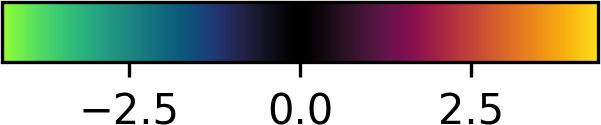

In [139]:
cb = infer_colorbar(None, cminmax=False, vmin=-v, vmax=v, cmap='cmr.wildfire', aspect=10, shrink=0.4);
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
#cbimg.save("retest_vertex_wise_corr.cbar.png"
cbimg

# Group average maps

In [14]:
from lib.plotting import fig2tightPIL, paste_centrally, image_grid

In [15]:
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);

In [18]:
mean_test_maps = tdata.mean(axis=0); 

n_contrasts = tdata.shape[-1]; 
v = np.absolute(mean_test_maps.flatten() ).max() *0.7

imgs = []
for nc in range(n_contrasts):
  print(nc, end=" ");
  imgs.append(make_tight_29k(mean_test_maps[:, nc], cbar=False, title=unique_contrasts[nc], cmap="coolwarm", cminmax=False, vmin=-v, vmax=v))


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

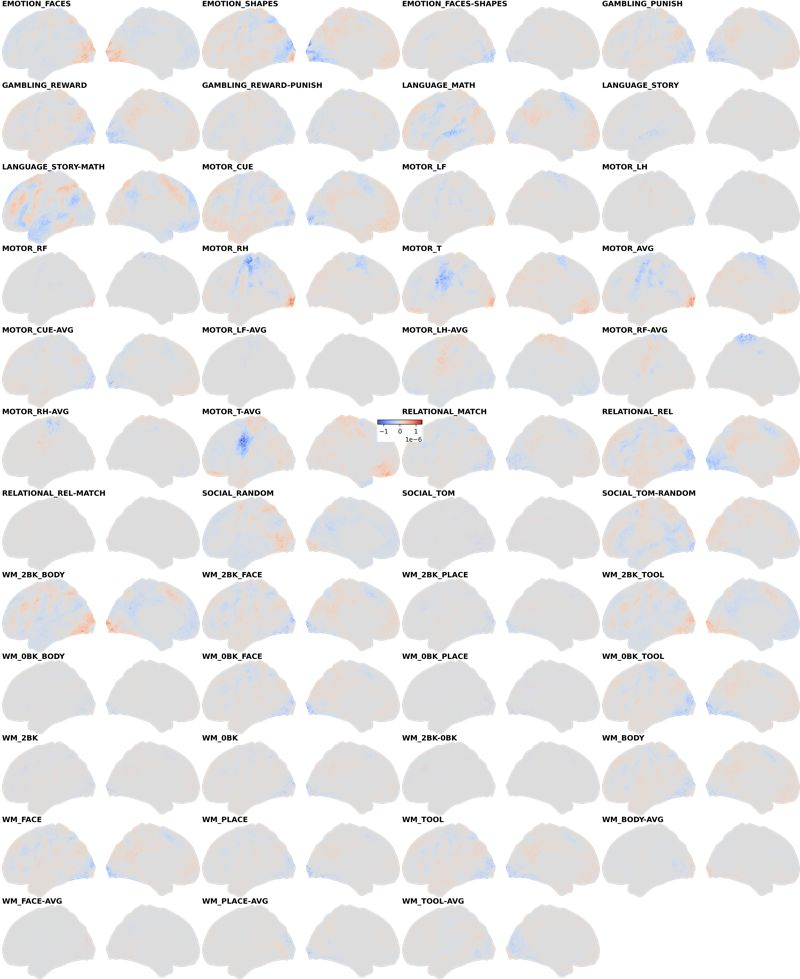

In [19]:
imgg = image_grid(imgs, int(n_contrasts/4)+1, 4)
cb = infer_colorbar(None, cminmax=False, vmin=-v, vmax=v, cmap="coolwarm", aspect=10, shrink=0.2);
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
imggcb = paste_centrally(imgg, cbimg , uc=-0.12);
imggcb.save("results/plots/all_test40_group_average_maps.png")
imggcb

# Full task maps

In [23]:
# loading task data
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
print(payload.keys())
tdata = payload["test_data"]
rdata = payload["retest_data"]

unique_contrasts = payload["info"]["unique_contrasts"]
subjs = payload["info"]["full_rt_subjs"]
zscore = payload["info"]["zscore"]
zscore, tdata.shape

dict_keys(['info', 'test_data', 'retest_data'])


(True, (40, 29696, 47))

In [ ]:
fn = "results/retest_hcp40.test.mean_task_maps47.from_zscored.npy"
mean_task_maps = tdata.mean(axis=0); 
print(mean_task_maps.shape)
#np.save(fn, dict(mean_task_maps=mean_task_maps, info=info))
!ls -ash {fn}

In [6]:
mean_task_maps = np.load("results/retest_hcp40.test.mean_task_maps47.from_zscored.npy", allow_pickle=1).item()["mean_task_maps"]
mean_task_maps.shape

(29696, 47)

## Test-Retest Scores

correlating test-retest per task within each participant

In [194]:
# inputs need to be of shape (n_subjs, n_tasks, n_vertices)
r = np.swapaxes(rdata, 1,2);
t = np.swapaxes(tdata, 1,2)
scoresd = compute_all_scores(r, t, avg_target=None, scores = desired_scores, scaled_resid = False)
differentiability = compute_batch_differentiability_score(r, t, reduce="no")
scoresd.corr.shape, differentiability.shape

((40, 47), (47,))

In [148]:
fn = "results/scores/retest_hcp.40subjs.47tasks.retest_scores.from_zscored.npy"
payl=dict(mean_corr = scoresd.corr.mean(0), diff = differentiability, scoresd= scoresd)
np.save(fn, payl)
!ls -ash {fn}

76K results/scores/retest_hcp.40subjs.47tasks.retest_scores.from_zscored.npy


## Find most differentiated contrasts

In [196]:
best_contrast_ids = np.argsort(differentiability)[::-1]
best_contrast_ids

for cn in best_contrast_ids[:15]: 
  print(unique_contrasts[cn][:38], "\t \t", differentiability[cn].round(4))

tfMRI_LANGUAGE_level2_STORY-MATH_hp200 	 	 0.2679
tfMRI_WM_level2_2BK_hp200_s2_MSMAll 	 	 0.2603
tfMRI_SOCIAL_level2_TOM_hp200_s2_MSMAl 	 	 0.2565
tfMRI_WM_level2_FACE_hp200_s2_MSMAll 	 	 0.2505
tfMRI_SOCIAL_level2_RANDOM_hp200_s2_MS 	 	 0.2468
tfMRI_GAMBLING_level2_REWARD_hp200_s2_ 	 	 0.2432
tfMRI_GAMBLING_level2_PUNISH_hp200_s2_ 	 	 0.2431
tfMRI_WM_level2_2BK_FACE_hp200_s2_MSMA 	 	 0.24
tfMRI_WM_level2_BODY_hp200_s2_MSMAll 	 	 0.2293
tfMRI_WM_level2_0BK_hp200_s2_MSMAll 	 	 0.2274
tfMRI_RELATIONAL_level2_REL_hp200_s2_M 	 	 0.2245
tfMRI_MOTOR_level2_CUE-AVG_hp200_s2_MS 	 	 0.2245
tfMRI_RELATIONAL_level2_MATCH_hp200_s2 	 	 0.2224
tfMRI_WM_level2_TOOL_hp200_s2_MSMAll 	 	 0.2208
tfMRI_MOTOR_level2_AVG_hp200_s2_MSMAll 	 	 0.2177


In [ ]:
# These are handselected from the output: 
# highest per task: ([8, 36, 26, 15, 3, 23, 2, 29]

# highest "actual" contrast per task (i.e. in the style of A-B)
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]

In [197]:
for cn in contrast_ids_to_show: 
  print(unique_contrasts[cn][:38], "\t \t", differentiability[cn].round(4))

tfMRI_LANGUAGE_level2_STORY-MATH_hp200 	 	 0.2679
tfMRI_WM_level2_2BK-0BK_hp200_s2_MSMAl 	 	 0.2097
tfMRI_MOTOR_level2_CUE-AVG_hp200_s2_MS 	 	 0.2245
tfMRI_EMOTION_level2_FACES-SHAPES_hp20 	 	 0.2177
tfMRI_SOCIAL_level2_TOM-RANDOM_hp200_s 	 	 0.1693
tfMRI_RELATIONAL_level2_REL-MATCH_hp20 	 	 0.1099
tfMRI_GAMBLING_level2_REWARD-PUNISH_hp 	 	 0.0354
tfMRI_WM_level2_FACE-AVG_hp200_s2_MSMA 	 	 0.1384
tfMRI_MOTOR_level2_T-AVG_hp200_s2_MSMA 	 	 0.1219


In [ ]:
#save as csv
#fn = "results/scores/retest_hcp.40subjs.47tasks.differentiability.from_zscored.csv"

## Group Mean Prediction Baseline

In [10]:
n_subjs = tdata.shape[0]
gdata = np.array([mean_task_maps for n in range(n_subjs)])
gdata.shape

(40, 29696, 47)

In [11]:
# inputs need to be of shape (n_subjs, n_tasks, n_vertices)
g = np.swapaxes(gdata, 1,2);
t = np.swapaxes(tdata, 1,2)
scoresd = compute_all_scores(g, t, avg_target=None, scores = desired_scores, scaled_resid = False)
differentiability = compute_batch_differentiability_score(g, t, reduce="no")
scoresd.corr.shape, differentiability.shape

((40, 47), (47,))

In [12]:
fn = "results/scores/retest_hcp.40subjs.47tasks.group_mean_scores.from_zscored.npy"
payl=dict(mean_corr = scoresd.corr.mean(0), diff = differentiability, scoresd= scoresd)
np.save(fn, payl)
!ls -ash {fn}

76K results/scores/retest_hcp.40subjs.47tasks.group_mean_scores.from_zscored.npy


## Vertex-wise accuracy maps

In [151]:
tdata.shape

(40, 29696, 47)

In [153]:
vwacc =compute_scores(rdata.transpose(1,2,0), tdata.transpose(1,2,0), score_fn= comp_corr)
vwacc.shape

(29696, 47)

In [154]:
fn = "results/scores/retest_hcp.40subjs.47tasks.vertexw_acc_across_subjs.from_zscored.npy"
np.save(fn, dict(info=payload["info"], vwmaps = vwacc))
!ls -ash {fn}

11M results/scores/retest_hcp.40subjs.47tasks.vertexw_acc_across_subjs.from_zscored.npy


In [156]:
n_contrasts = tdata.shape[-1]; 
v = np.absolute(vwacc[:, contrast_ids_to_show].flatten() ).max()

imgs = []
for nc in contrast_ids_to_show:
  imgs.append(make_tight_29k(vwacc[:, nc], cbar=False, title=uncontr[nc], cminmax=False, vmin=-v, vmax=v))


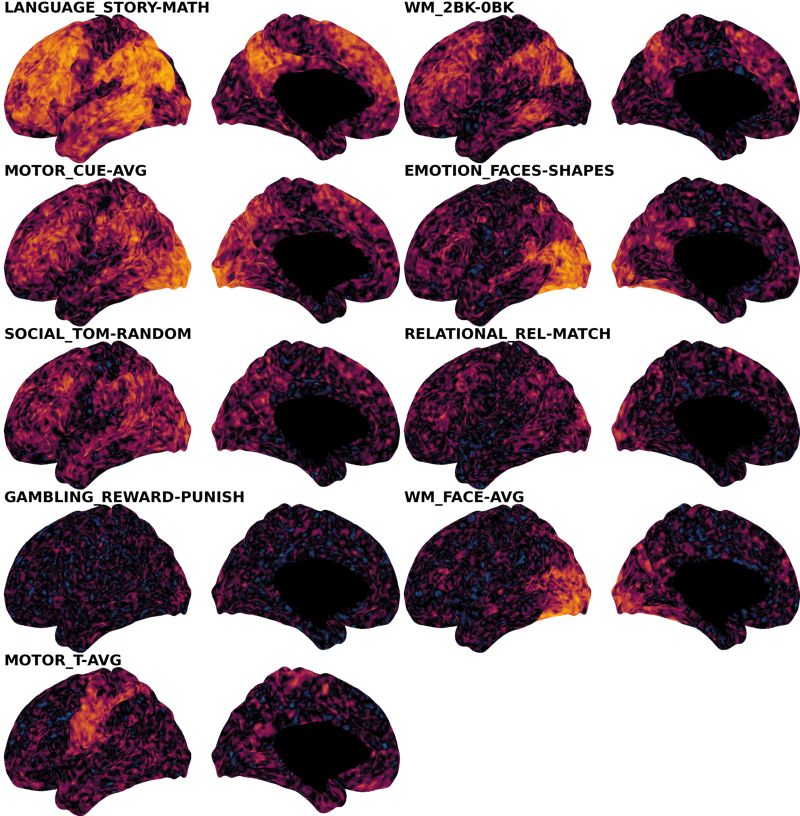

In [157]:
image_grid(imgs, 5,2)

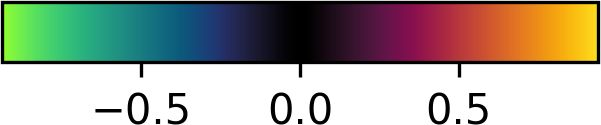

In [158]:
cb = infer_colorbar(None, cminmax=False, vmin=-v, vmax=v, cmap='cmr.wildfire', aspect=10, shrink=0.4);
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
cbimg.save("retest_vertex_wise_corr.cbar.png")
cbimg

## Within parcel discriminability

In [25]:
## Load the parcellation(s)

from brainspace.datasets import load_parcellation
import hcp_utils as hcp

lh_parc, rh_parc = load_parcellation('schaefer')
print("Schaefer400:\t",lh_parc.shape, lh_parc[hcp.vertex_info["grayl"]].shape)
print("HCP MMP1:\t",hcp.mmp.map_all[:29696].shape)

parcellation29k = hcp.mmp.map_all[:29696];
parcel_id_to_label = hcp.mmp.labels;

Schaefer400:	 (32492,) (29696,)
HCP MMP1:	 (29696,)


In [26]:
from tqdm.auto import tqdm
from lib.stats import comp_dice, comp_corr, r2_score
from lib.stats import compute_all_scores, compute_scores, compute_batch_differentiability_score
from lib.linear_models import score

uniq_labels = list(np.unique(parcellation29k));
n_parcels = len(uniq_labels) # all labels in the left hemisphere

y_test = rdata
y_test_pred = tdata

n_tasks = y_test_pred.shape[-1]; 

corrs = np.zeros((n_parcels, n_tasks))
diffs = np.zeros((n_parcels, n_tasks))

pbar = tqdm(enumerate(uniq_labels), total=n_parcels)
for i, label_val in pbar:
    label = "" if parcel_id_to_label is None else parcel_id_to_label[label_val]
    mask = parcellation29k == label_val
    pbar.update()
    pbar.set_postfix_str(f"#{label_val} {label}, {mask.sum()}")
    if mask.sum()< 1: continue;
    scoresd, diff_scores_test = score(y_test_pred[:, mask, :], y_test[:, mask, :]);
    corrs[i, :] = scoresd.corr.mean(axis=0)
    diffs[i, :] = diff_scores_test

    

  0%|          | 0/180 [00:00<?, ?it/s]

In [27]:
fn = "results/scores/retest_hcp.40subjs.47tasks.within_parcel.yfull.from_zscored.npy"
np.save(fn, dict(info=payload["info"], corrs = corrs, diffs = diffs, parcellation29k=parcellation29k ))
!ls -ash {fn}

376K results/scores/retest_hcp.40subjs.47tasks.within_parcel.yfull.from_zscored.npy


_____

_____________________

# Residualized task data

## Residualization

In [6]:
# loading task data
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
print(payload.keys())
tdata = payload["test_data"]
rdata = payload["retest_data"]

unique_contrasts = payload["info"]["unique_contrasts"]
subjs = payload["info"]["full_rt_subjs"]
zscore = payload["info"]["zscore"]
zscore, tdata.shape

dict_keys(['info', 'test_data', 'retest_data'])


(True, (40, 29696, 47))

In [7]:
mean_task_maps = np.load("results/retest_hcp40.test.mean_task_maps47.from_zscored.npy", allow_pickle=1).item()["mean_task_maps"]
mean_task_maps.shape

(29696, 47)

In [8]:
from lib.stats import batch_resid, residualize

confounds = mean_task_maps;

n_tasks = tdata.shape[-1]
n_subjs = tdata.shape[0]

tdata_resid = np.zeros_like(tdata)
rdata_resid = np.zeros_like(rdata)

for tn in range(n_tasks):
    for sn in range(n_subjs):
        tdata_resid[sn, :, tn] = residualize(tdata[sn, :, tn], confounds[:, tn]) # test
        rdata_resid[sn, :, tn] = residualize(rdata[sn, :, tn], confounds[:, tn]) # test

rdata_resid.shape

/usr/users/robert.scholz2/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(40, 29696, 47)

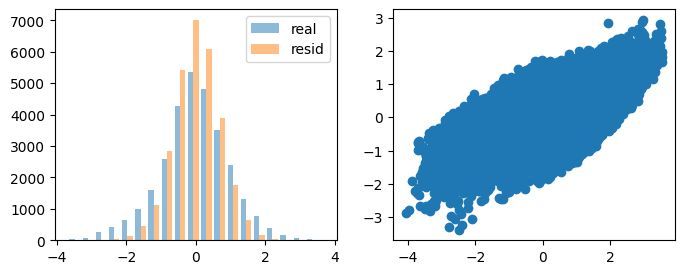

In [11]:
from matplotlib import pyplot as plt
# check if this kinda worked
a = tdata[0,:,8]
b = tdata_resid[0,:,8]
v = np.absolute(np.concatenate((a.flatten(),b.flatten()))).max()

fig, axs = plt.subplots(1,2, figsize=(8,3)) # 4 plots in a row
axs[0].hist([a,b], bins = 20, alpha=0.5, label=['real', 'resid']); axs[0].legend(['real', 'resid']); axs[0].set_xlim(-v,v);
axs[1].scatter(a,b);

In [13]:
fn = "results/retest_hcp40.task_maps47.yresid.from_zscored.npy"
print(tdata.shape, rdata.shape)
np.save(fn, dict(info=payload["info"], test_data = tdata_resid, retest_data = rdata_resid ))
!ls -ash {fn}

(40, 29696, 47) (40, 29696, 47)
463M results/retest_hcp40.task_maps47.yresid.from_zscored.npy


In [166]:
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.yresid.from_zscored.npy"
print(tdata.shape, rdata.shape)
np.save(fn, dict(info=payload["info"], test_data = tdata_resid, retest_data = rdata_resid ))
!ls -ash {fn}

(40, 29696, 47) (40, 29696, 47)
426M /scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.yresid.from_zscored.npy


## Test-Retest Scores

correlating test-retest per task within each participant

In [5]:
# loading task data
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.yresid.from_zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
print(payload.keys())
tdata = payload["test_data"]
rdata = payload["retest_data"]

unique_contrasts = payload["info"]["unique_contrasts"]
subjs = payload["info"]["full_rt_subjs"]
zscore = payload["info"]["zscore"]
zscore, tdata.shape

dict_keys(['info', 'test_data', 'retest_data'])


(True, (40, 29696, 47))

In [6]:
mean_task_maps = tdata.mean(axis=0); 
print(mean_task_maps.shape)

(29696, 47)


In [168]:
# inputs need to be of shape (n_subjs, n_tasks, n_vertices)
r = np.swapaxes(rdata, 1,2);
t = np.swapaxes(tdata, 1,2);
scoresd = compute_all_scores(r, t, avg_target=None, scores = desired_scores, scaled_resid = False)
differentiability = compute_batch_differentiability_score(r, t, reduce="no")
scoresd.corr.shape, differentiability.shape

((40, 47), (47,))

In [169]:
fn = "results/scores/retest_hcp.40subjs.47tasks.retest_scores.yresid.from_zscored.npy"
payl=dict(mean_corr = scoresd.corr.mean(0), diff = differentiability, scoresd= scoresd, info=payload["info"])
np.save(fn, payl)
!ls -ash {fn}

88K results/scores/retest_hcp.40subjs.47tasks.retest_scores.yresid.from_zscored.npy


## Group Mean Prediction Baseline 

(should be all zero)

In [190]:
gdata = np.array([mean_task_maps for n in range(n_subjs)])
print(gdata.shape)

# inputs need to be of shape (n_subjs, n_tasks, n_vertices)
g = np.swapaxes(gdata, 1,2);
t = np.swapaxes(tdata, 1,2)
scoresd = compute_all_scores(g, t, avg_target=None, scores = desired_scores, scaled_resid = False)
differentiability = compute_batch_differentiability_score(g, t, reduce="no")
print(scoresd.corr.shape, differentiability.shape)

print(scoresd.corr.mean(0).round(2))
print(differentiability.round(2))

(40, 29696, 47)
(40, 47) (47,)
[ 0. -0.  0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0. -0.
 -0.  0.  0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0.  0. -0.
 -0. -0. -0.  0.  0. -0.  0. -0. -0.  0.  0.]
[-0.  0. -0.  0.  0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0.
  0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0.]


## Vertex-wise accuracy maps

In [7]:
vwacc =compute_scores(rdata.transpose(1,2,0), tdata.transpose(1,2,0), score_fn= comp_corr)
vwacc.shape

(29696, 47)

In [ ]:
fn = "results/scores/retest_hcp.40subjs.47tasks.vertexw_acc_across_subjs.yresid.from_zscored.npy"
np.save(fn, dict(info=payload["info"], vwmaps = vwacc))
!ls -ash {fn}

In [184]:
n_contrasts = tdata.shape[-1]; 
v = np.absolute(vwacc[:, contrast_ids_to_show].flatten() ).max()

imgs = []
for nc in contrast_ids_to_show:
  imgs.append(make_tight_29k(vwacc[:, nc], cbar=False, title=uncontr[nc], cminmax=False, vmin=-v, vmax=v))


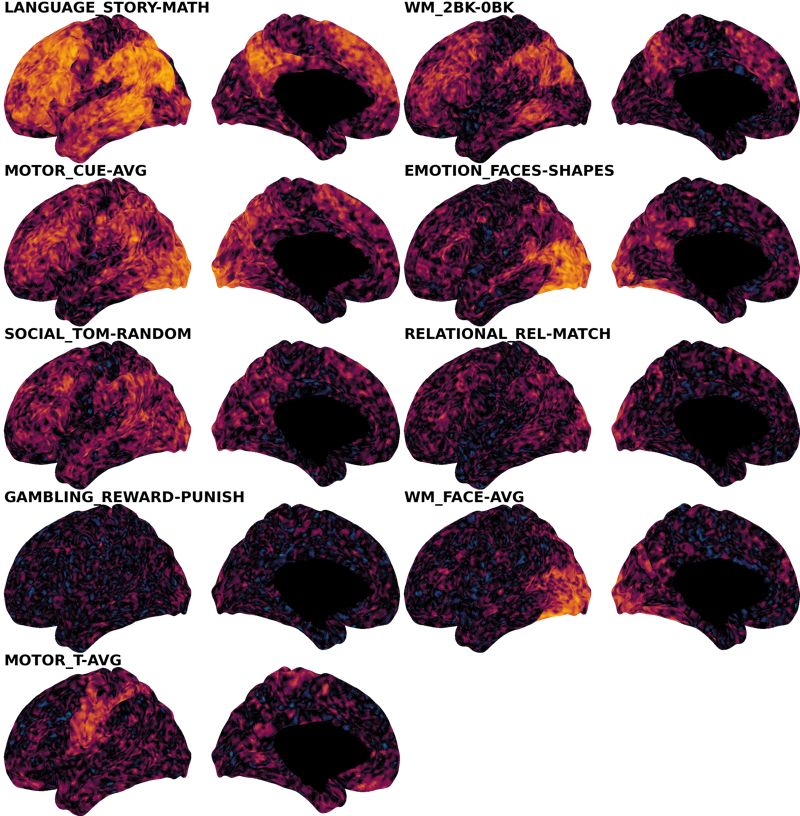

In [187]:
# seems to be exactly the same as their non-residualized pendant
image_grid(imgs, 5,2)

# Summary: Which tasks to visualize?

In [ ]:
## Most replicable contrasts (also including contrasts against implicit baselines)

tfMRI_LANGUAGE_level2_STORY-MATH_hp200 	 	 0.2506
tfMRI_WM_level2_2BK_hp200_s2_MSMAll 	 	 0.2479
tfMRI_SOCIAL_level2_TOM_hp200_s2_M 	 	 0.2446
tfMRI_MOTOR_level2_AVG_hp200_s2_MSMAll 	 	 0.2356
tfMRI_GAMBLING_level2_PUNISH_hp200_s2_ 	 	 0.234
tfMRI_RELATIONAL_level2_REL_hp200_s2_M 	 	 0.2234
tfMRI_EMOTION_level2_FACES-SHAPES_hp20 	 	 0.2066

// optional
tfMRI_WM_level2_2BK_FACE_hp200_s2_MSMA 	 	 0.2354


## Most replicable actual contrasts 

tfMRI_LANGUAGE_level2_STORY-MATH_hp200 	 	 0.2506
tfMRI_WM_level2_2BK-0BK_hp200_s2_MSMAl 	 	 0.2337
tfMRI_MOTOR_level2_CUE-AVG_hp200_s2_MS 	 	 0.2099
tfMRI_EMOTION_level2_FACES-SHAPES_hp20 	 	 0.2066
tfMRI_SOCIAL_level2_TOM-RANDOM_hp200_s 	 	 0.1775
tfMRI_RELATIONAL_level2_REL-MATCH_hp20 	 	 0.1439
tfMRI_GAMBLING_level2_REWARD-PUNISH_hp 	 	 0.0322

// optional
tfMRI_WM_level2_FACE-AVG_hp200_s2_MSMA 	 	 0.1652
tfMRI_MOTOR_level2_T-AVG_hp200_s2_MSMA 	 	 0.1181

In [12]:
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);

In [23]:
xxx = ["tfMRI_LANGUAGE_level2_STORY-MATH_hp200", "tfMRI_WM_level2_2BK-0BK_hp200_s2_MSMAl", "tfMRI_MOTOR_level2_CUE-AVG_hp200_s2_MS", "tfMRI_EMOTION_level2_FACES-SHAPES_hp20", "tfMRI_SOCIAL_level2_TOM-RANDOM_hp200_s", "tfMRI_RELATIONAL_level2_REL-MATCH_hp20", "tfMRI_GAMBLING_level2_REWARD-PUNISH_hp", "tfMRI_WM_level2_FACE-AVG_hp200_s2_MSMA", "tfMRI_MOTOR_level2_T-AVG_hp200_s2_MSMA"]
idxs = []
for c in xxx:
   dada = [uc.startswith(c) for uc in unique_contrasts]
   # print(c, dada)
   idxs.append(np.argwhere(dada)[0][0])

idxs, unique_contrasts[idxs]

([8, 38, 16, 2, 27, 24, 5, 44, 21],
 array(['tfMRI_LANGUAGE_level2_STORY-MATH_hp200_s2_MSMAll',
        'tfMRI_WM_level2_2BK-0BK_hp200_s2_MSMAll',
        'tfMRI_MOTOR_level2_CUE-AVG_hp200_s2_MSMAll',
        'tfMRI_EMOTION_level2_FACES-SHAPES_hp200_s2_MSMAll',
        'tfMRI_SOCIAL_level2_TOM-RANDOM_hp200_s2_MSMAll',
        'tfMRI_RELATIONAL_level2_REL-MATCH_hp200_s2_MSMAll',
        'tfMRI_GAMBLING_level2_REWARD-PUNISH_hp200_s2_MSMAll',
        'tfMRI_WM_level2_FACE-AVG_hp200_s2_MSMAll',
        'tfMRI_MOTOR_level2_T-AVG_hp200_s2_MSMAll'], dtype='<U51'))

In [ ]:
np.savetxt("data/task_contrasts_indices_most_replicable_for_vis.txt", unique_contrasts, fmt="%s")
np.savetxt("data/task_contrasts_indices_most_replicable_actual_contrasts_for_vis.txt", unique_contrasts, fmt="%s")